## Data Pre-Processing

In [1]:
import pandas as pd

In [2]:
movies = pd.read_csv('../data/movies/ml-latest-small/ratings.csv')

In [3]:
movies.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [5]:
len(movies.movieId.unique()), len(movies.userId.unique())

(9724, 610)

so 9724 movies and 610 users exist

Lets do a categorical mapping for users and movies

In [6]:
movies.movieId = movies.movieId.astype('category').cat.codes.values
movies.userId = movies.userId.astype('category').cat.codes.values

In [7]:
movies.head()

,userId,movieId,rating,timestamp
0,0,0,4.0,964982703
1,0,2,4.0,964981247
2,0,5,4.0,964982224
3,0,43,5.0,964983815
4,0,46,5.0,964982931


In [8]:
from sklearn.model_selection import train_test_split

In [9]:
train, test = train_test_split(movies, test_size = 0.2)

In [10]:
train.head()

,userId,movieId,rating,timestamp
57015,379,835,4.0,1493419978
48628,313,234,3.0,834398583
90124,585,4126,4.0,1529901830
52134,338,3635,5.0,1460183309
45536,300,116,4.0,1211378832


In [11]:
test.head()

,userId,movieId,rating,timestamp
19697,128,546,4.0,1167376093
42278,287,856,2.0,976138852
64468,413,6039,4.0,1149889923
83898,533,7070,3.5,1459787998
16417,104,3741,3.5,1446749962


## Matrix Factorisation For Recommendation

In [12]:
import keras
from IPython.display import SVG
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [29]:
from keras.callbacks import EarlyStopping

In [31]:
early_callback = EarlyStopping(monitor='loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)

In [32]:
n_users, n_movies = len(movies.userId.unique()), len(movies.movieId.unique())

In [33]:
n_embeddings = 30

In [34]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [35]:
movie_input = keras.layers.Input(shape=[1], name = 'Movie')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_embeddings, name = 'Movie-Embeddings')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

user_input = keras.layers.Input(shape=[1], name = 'User')
user_embedding = keras.layers.Embedding(n_users + 1, n_embeddings, name = 'User-Embeddings')(user_input)
user_vec = keras.layers.Flatten(name='FlattenUsers')(user_embedding)

In [36]:
prod = keras.layers.Dot(axes = 1, name='DotProduct')([movie_vec, user_vec])
model = keras.Model([user_input, movie_input], prod)
model.compile('adam', 'mean_squared_error')

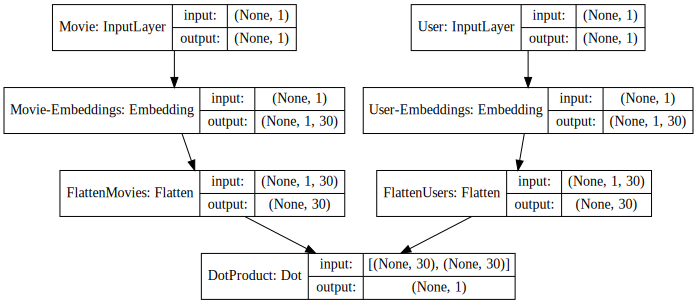

In [37]:
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [38]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Movie (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embeddings (Embedding)    (None, 1, 30)        291750      Movie[0][0]                      
__________________________________________________________________________________________________
User-Embeddings (Embedding)     (None, 1, 30)        18330       User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

In [39]:
history = model.fit([train.userId, train.movieId], train.rating, epochs=50, verbose=0, callbacks=[early_callback])

Text(0,0.5,'Train Error')

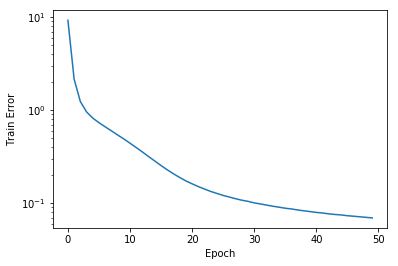

In [40]:
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")

In [42]:
y_hat = np.round(model.predict([test.userId, test.movieId]),0)
y_true = test.rating

In [43]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, y_hat)

0.9455573185243951

In [44]:
y_hat[0:5]

array([[4.],
       [3.],
       [3.],
       [4.],
       [4.]], dtype=float32)

In [45]:
y_true[0:5]

19697    4.0
42278    2.0
64468    4.0
83898    3.5
16417    3.5
Name: rating, dtype: float64

Get the embeddings

In [46]:
movie_embeddings_learnt = model.get_layer(name='Movie-Embeddings').get_weights()[0]

In [47]:
movie_embeddings_learnt.shape

(9725, 30)

In [49]:
pd.DataFrame(movie_embeddings_learnt).describe()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
count,9725.000000,9725.000000,9725.000000,9725.000000,9725.000000,9725.000000,9725.000000,9725.000000,9725.000000,9725.000000,...,9725.000000,9725.000000,9725.000000,9725.000000,9725.000000,9725.000000,9725.000000,9725.000000,9725.000000,9725.000000
mean,-0.182424,0.210946,0.206134,-0.198827,0.210936,-0.208338,0.208638,-0.198807,-0.197395,-0.213909,...,0.202548,-0.209722,0.201172,0.210375,-0.201790,0.195905,-0.210638,0.203551,0.211969,0.176438
std,0.203921,0.170063,0.189924,0.212097,0.167188,0.177144,0.167503,0.196568,0.226600,0.165241,...,0.182511,0.177421,0.201390,0.167095,0.198665,0.196980,0.163397,0.183783,0.168302,0.215921
min,-1.507595,-0.952945,-0.911023,-1.416113,-0.897386,-1.339413,-1.205533,-1.332472,-1.257358,-1.308766,...,-0.929003,-1.270800,-0.992702,-0.804780,-1.459668,-0.754190,-1.332909,-0.942191,-0.882951,-1.457903
25%,-0.289164,0.123035,0.096832,-0.306041,0.127663,-0.291222,0.127755,-0.291856,-0.308318,-0.289706,...,0.104177,-0.290250,0.083156,0.127437,-0.297909,0.087751,-0.287070,0.105202,0.128905,0.051914
50%,-0.196291,0.220333,0.210167,-0.200316,0.218587,-0.214171,0.217180,-0.201822,-0.207252,-0.219346,...,0.212855,-0.217240,0.208843,0.218423,-0.206704,0.212178,-0.219993,0.213679,0.219530,0.197224
75%,-0.060459,0.291852,0.294894,-0.063839,0.288172,-0.116262,0.287217,-0.081439,-0.059838,-0.126048,...,0.288768,-0.118939,0.295632,0.286282,-0.088498,0.292507,-0.128895,0.290948,0.285466,0.284438
max,1.240571,1.218372,1.353457,1.271724,1.290477,0.907263,1.313625,1.162862,0.941366,0.616194,...,1.401328,1.028579,1.289212,1.436872,0.832514,1.550220,0.874152,1.476346,1.881157,1.419894


In [50]:
user_embeddings_learnt = model.get_layer(name='User-Embeddings').get_weights()[0]
pd.DataFrame(user_embeddings_learnt).describe()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
count,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,...,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000
mean,-0.377098,0.483424,0.488390,-0.499309,0.472991,-0.479263,0.473800,-0.474013,-0.496057,-0.496211,...,0.503612,-0.490633,0.483112,0.488826,-0.466283,0.370634,-0.478245,0.485973,0.479168,0.403760
std,0.601237,0.473815,0.481915,0.486809,0.491100,0.482297,0.470163,0.470494,0.547885,0.445018,...,0.497301,0.470853,0.529957,0.478579,0.572657,0.661826,0.492050,0.497160,0.482776,0.644223
min,-2.665604,-1.239934,-1.135680,-2.159966,-1.524699,-2.732786,-1.338261,-1.698696,-3.208124,-2.136268,...,-1.068283,-1.953142,-1.921680,-1.070979,-2.429818,-2.187976,-2.296484,-1.621713,-1.629278,-2.974298
25%,-0.755025,0.206137,0.184727,-0.792968,0.168108,-0.777974,0.163622,-0.802360,-0.852446,-0.803727,...,0.152053,-0.819248,0.141625,0.169490,-0.836578,-0.024422,-0.773184,0.167154,0.215249,0.027426
50%,-0.370617,0.470726,0.480365,-0.517506,0.492972,-0.471215,0.472636,-0.488670,-0.488620,-0.498001,...,0.491726,-0.496596,0.497973,0.506240,-0.502820,0.396511,-0.458195,0.487896,0.488274,0.438259
75%,0.032067,0.800656,0.780607,-0.201640,0.806815,-0.181208,0.818905,-0.166506,-0.146958,-0.203990,...,0.842944,-0.185695,0.827444,0.806969,-0.113707,0.812325,-0.183997,0.814800,0.779076,0.790671
max,1.866594,2.215248,1.792605,1.003806,2.340250,1.136775,1.935569,1.029209,1.014010,0.959991,...,2.477475,1.127445,2.639040,1.979641,1.601362,2.614203,1.281564,2.085564,2.838708,2.103703


## Feed Forward Network For Recommendation

In [51]:
n_latent_movies = 30
n_latent_users = 15

movie_input = keras.layers.Input(shape=[1], name = 'Movie')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_movies, name = 'Movie-Embeddings')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)
movie_vec = keras.layers.Dropout(0.2)(movie_vec)

user_input = keras.layers.Input(shape=[1], name = 'User')
user_embedding = keras.layers.Embedding(n_users + 1, n_latent_users, name = 'User-Embeddings')(user_input)
user_vec = keras.layers.Flatten(name='FlattenUsers')(user_embedding)
user_vec = keras.layers.Dropout(0.2)(user_vec)

In [61]:
concat = keras.layers.Concatenate(axis=1 ,name='Concat')([movie_vec, user_vec])
concat_dropout = keras.layers.Dropout(0.2)(concat)
dense = keras.layers.Dense(200, name ='FullyConnected', activation='relu')(concat)
dropout_1 = keras.layers.Dropout(0.2,name='Dropout-1')(dense)
dense_2 = keras.layers.Dense(100,name='FullyConnected-1', activation='relu')(dropout_1)
dropout_2 = keras.layers.Dropout(0.2,name='Dropout-2')(dense_2)
dense_3 = keras.layers.Dense(50,name='FullyConnected-2', activation='relu')(dropout_2)
dropout_3 = keras.layers.Dropout(0.2,name='Dropout-3')(dense_3)
dense_4 = keras.layers.Dense(20,name='FullyConnected-3', activation='relu')(dropout_3)

In [62]:
result = keras.layers.Dense(1, activation='relu',name='Activation')(dense_4)
adam = Adam(lr=0.005)
model = keras.Model([user_input, movie_input], result)
model.compile(optimizer=adam,loss= 'mean_absolute_error')

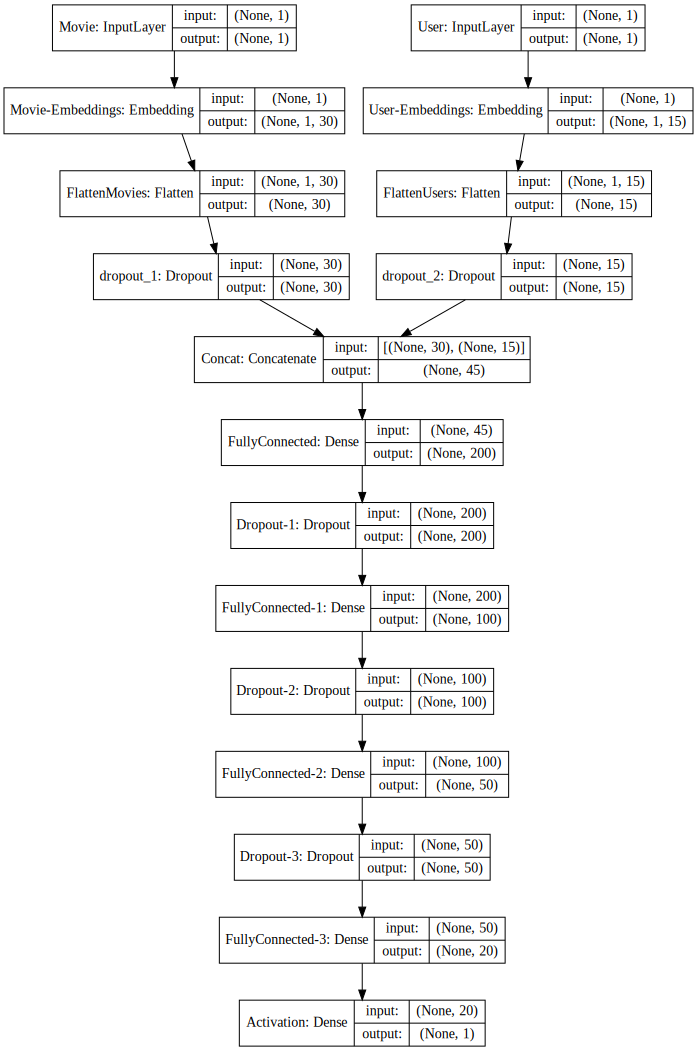

In [63]:
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [64]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Movie (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embeddings (Embedding)    (None, 1, 30)        291750      Movie[0][0]                      
__________________________________________________________________________________________________
User-Embeddings (Embedding)     (None, 1, 15)        9165        User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

In [65]:
history = model.fit([train.userId, train.movieId], train.rating, epochs=200, verbose=1, callbacks=[early_callback])

Epoch 1/200
80668/80668 [==============================] - 18s 224us/step - loss: 0.7582
Epoch 2/200
80668/80668 [==============================] - 15s 183us/step - loss: 0.6818
Epoch 3/200
80668/80668 [==============================] - 15s 183us/step - loss: 0.6700
Epoch 4/200
80668/80668 [==============================] - 15s 183us/step - loss: 0.6628
Epoch 5/200
80668/80668 [==============================] - 15s 183us/step - loss: 0.6559
Epoch 6/200
80668/80668 [==============================] - 15s 183us/step - loss: 0.6536
Epoch 7/200
80668/80668 [==============================] - 15s 183us/step - loss: 0.6472
Epoch 8/200
80668/80668 [==============================] - 15s 183us/step - loss: 0.6477


In [67]:
y_hat_2 = np.round(model.predict([test.userId, test.movieId]),0)
print(mean_absolute_error(y_true, y_hat_2))

print(mean_absolute_error(y_true, model.predict([test.userId, test.movieId])))

0.6854918683062277
0.6870196399377575


In [68]:
y_hat_2[:5]

array([[4.],
       [3.],
       [3.],
       [4.],
       [4.]], dtype=float32)

In [69]:
y_true[:5]

19697    4.0
42278    2.0
64468    4.0
83898    3.5
16417    3.5
Name: rating, dtype: float64

For the second case we input concat[user_embedding, movie_embedding] as input to get the erecommendations